<a href="https://colab.research.google.com/github/hugofung919/Comp3516_group/blob/main/Comp3516_group08_Floor_level_localization_using_smartphones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sprint 1: Signal Processing Approach**

1. Load the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

2. Load the barometer readings from a file or sensor

In [ ]:
df = pd.read_csv('Raw Data.csv')

3. Filter the collected data

Since we are walking with the device, there would be fluctuations in the barometer reading. To eliminate these effects and ensure that the change in air pressure is purely caused by change in floor level, we filter out these noises and use the filtered air pressure data for analysis.

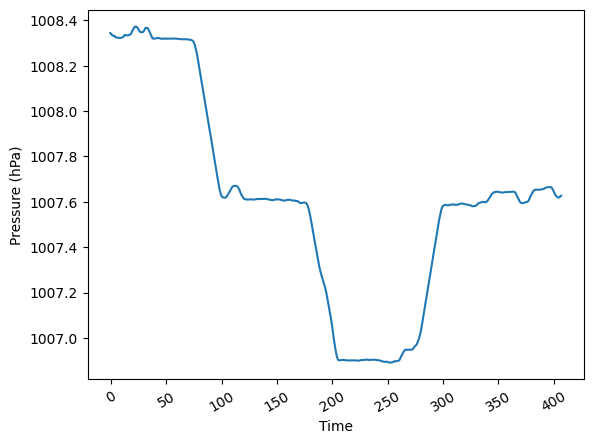

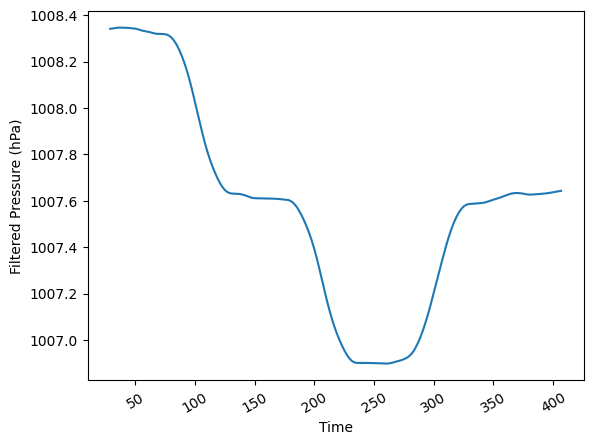

In [ ]:
# Set the index of the dataframe as the time column
df = df.set_index('Time (s)')

# Plot time series graph of the pressure data
plt.plot(df.index, df['Pressure (hPa)'])
plt.xlabel('Time')
plt.ylabel('Pressure (hPa)')
plt.xticks(rotation=30)
plt.show()

# Set the size of the moving average window
window_size = 30

# Apply the moving average filter to the 'Pressure (hPa)' column
df['pressure_filtered'] = df['Pressure (hPa)'].rolling(window_size).mean()

# Plot time series graph of the pressure data
plt.plot(df.index, df['pressure_filtered'])
plt.xlabel('Time')
plt.ylabel('Filtered Pressure (hPa)')
plt.xticks(rotation=30)
plt.show()

barometer_readings = df['pressure_filtered'].values

# Replace NaN values with the original pressure readings
for i in range(barometer_readings.size):
    if (math.isnan(barometer_readings[i])):
        barometer_readings[i] = (df['Pressure (hPa)'].values)[i]


4. Output the floor level of the user and the respective time

Several parameters are initialized, including the number of data points to use for slope calculation, the minimum slope required to trigger a floor level change, and the required difference in air pressure that signifies a floor change.

In [ ]:
# Set the number of data points to use for slope calculation
SLOPE_PERIOD = 15

# Set the minimum slope required to trigger a floor level change
SLOPE_THRESHOLD = 0.008

# Set the required difference between the two stable readings to trigger a floor level change
REQ_DIFF = 0.1

5. Output the floor level of the user and the respective 

The floor level is initialized to be 0 which limits the program to only calculating the relative floor level, leading to the first limitation of this approach.

The program loops through the data points within the time period. Within each loop, we take (i)th to (i + SLOPE_PERIOD)th barometer reading to calculate the slope using numpy's polyfitfunction. If the absolute value of the slope is below the threshold, it is assumed that the reading is stable. If the reading is significantly different from the latest stable reading, the floor level is assumed to have changed.

The variable: latest stable reading is recorded as a reference to check if the user has transitted to another level. The latest stable reading is not changed when the person is on the floor (i.e. the air pressure of the device is generally the same with the previously-obtained data). This indicator will change under three circumstances:

(i) The person just went up a floor 

(ii) The person just went down a floor 

(iii) The person is during the process of moving to another floor (i.e. on an escalator) or putting down their device 


If the absolute value of the barometer reading is significantly different from the latest stable reading, it is considered that the floor level has been changed. It is to ensure that the difference in air pressure is large enough so that we can eliminate the effect of not steadily holding the device on the same floor. The latest stable reading is then set to the current reading when the new floor level is printed.

In [ ]:
# Initialize the floor level and latest stable reading
floor_level = 0
latest_stable_reading = barometer_readings[0]

# Loop through the data points in the time period
for i in range(len(barometer_readings)-SLOPE_PERIOD):

    # Calculate the slope of the previous SLOPE_PERIOD data points
    slope = np.polyfit(range(SLOPE_PERIOD), barometer_readings[i:i+SLOPE_PERIOD], 1)[0]
    
    # If the slope is below the threshold, assume it's stable
    if abs(slope) < SLOPE_THRESHOLD:

        # If the reading is significantly different from the latest stable reading, assume the floor level changed
        if abs(barometer_readings[i] - latest_stable_reading) > REQ_DIFF:

            # If the reading is higher, assume the person went down a floor
            if barometer_readings[i] > latest_stable_reading:            
                floor_level -= 1

                # Set the latest stable reading to the current reading
                latest_stable_reading = barometer_readings[i]

                # Print the new floor level
                print("Person arrived on floor ", floor_level, " at t = ", df.index[i], "s", sep="")

            # If the reading is lower, assume the person went up a floor
            elif barometer_readings[i] < latest_stable_reading:
                floor_level += 1

                # Set the latest stable reading to the current reading
                latest_stable_reading = barometer_readings[i]

                # Print the new floor level
                print("Person arrived on floor ", floor_level, " at t = ", df.index[i], "s", sep="")

        else:
            pass

    # If the slope is above the threshold, assume the reading is still changing
    else:
        latest_stable_reading = barometer_readings[i]

Person arrived on floor 1 at t = 125.691118s
Person arrived on floor 2 at t = 231.708872s
Person arrived on floor 1 at t = 325.001663s


# **Sprint 2 Machine Learning**
**The design of the floor detection system consists of three main components: data collection and dataset creation, deep learning model training, and floor detection using the trained deep learning model. Figure 3 provides an overview of the Deep Learning Convolutional Neural Network (DL-CNN) floor detection process design, illustrating the main components and their interactions.**


**Data Collection and Dataset:** The system collects barometer readings from a smartphone and stores the data in a database. This dataset includes features such as seconds elapsed, relative altitude, and atmospheric pressure, which serve as input to the deep learning model training process.

**Deep Learning Model Training:** In this phase, the collected data undergoes preprocessing and human labeling to ensure accuracy. The data is then used to train a deep learning model, specifically a 1D Convolutional Neural Network (CNN), which is designed to handle time-series sensor data effectively. The model is trained on the preprocessed and labeled data, with the goal of learning to predict the correct floor number based on the input features.

**Floor Detection with the Trained Deep Learning Model:** Once the CNN model is trained, it can be used to detect the floor number in real-time. The system inputs time-series barometer data from the smartphone into the trained model, which then outputs the detected floor number. This allows users to identify their current floor in a building based on the sensor data.

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
tf.random.set_seed(42)

# **Data Collection**
Using the "Sensor Logger" application, sensor data, including seconds elapsed, relative altitude, and atmospheric pressure, were collected from a smartphone. To ensure dataset accuracy, a manual labeling process was carried out to assign the correct floor numbers to the collected data.


In [ ]:
data = pd.read_csv('train_set.csv')
data.dropna(inplace=True) # drop all data with na
data.head(10) # display first 10 data

,time,seconds_elapsed,relativeAltitude,pressure,Floor
0,1.681640e+18,-0.363810,0.000000,1008.104477,G
1,1.681640e+18,0.666242,-0.018494,1008.106461,G
2,1.681640e+18,1.696307,-0.034348,1008.108444,G
3,1.681640e+18,2.726326,-0.036991,1008.108826,G
4,1.681640e+18,3.756358,-0.036991,1008.108826,G
5,1.681640e+18,3.952356,-0.036991,1008.108826,G
6,1.681640e+18,5.015659,-0.031708,1008.108063,G
7,1.681640e+18,6.078951,-0.036991,1008.108902,G
8,1.681640e+18,7.142245,-0.039635,1008.109207,G
9,1.681640e+18,8.205521,-0.068699,1008.112564,G


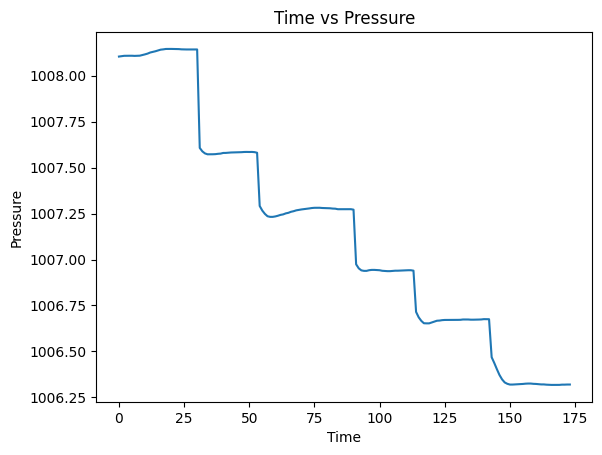

In [ ]:
# Time vs Pressure
plt.title("Time vs Pressure")
plt.xlabel("Time")
plt.ylabel("Pressure")
plt.plot(range(0, data.shape[0]), data['pressure'])

                  seconds_elapsed  relativeAltitude  pressure
seconds_elapsed          1.000000          0.989053 -0.989041
relativeAltitude         0.989053          1.000000 -1.000000
pressure                -0.989041         -1.000000  1.000000


<ipython-input-51-c6d3f9bfc287>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data[['seconds_elapsed','relativeAltitude','pressure','Floor']].corr()


<Axes: >

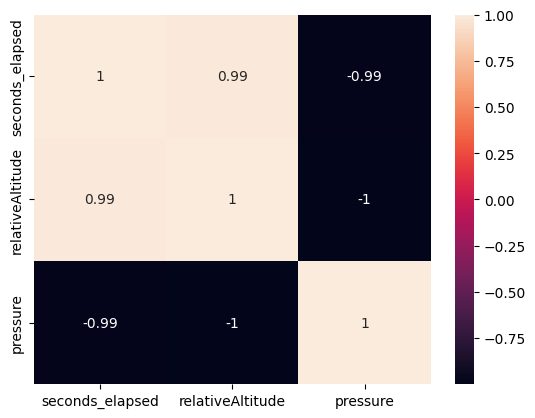

In [ ]:
# Use Pearson Correlation Coefficient
corr = data[['seconds_elapsed','relativeAltitude','pressure','Floor']].corr()
print(corr)
# Visualize Pearson Correlation Coefficient
sns.heatmap(corr, annot=True)

# **Data Preprocessing**
Data preprocessing involved importing data with the pandas library, removing missing values (NA), and visualizing the relationship between features and the target variable (floor number).
# **Feature Engineering**
Custom functions 'transformFloor()' and 'nomoralizePressure()' were developed for data transformation and normalization. Floor numbers were converted from strings to integers, and atmospheric pressure was normalized.

In [ ]:
# Preprocessing and feature extraction
def transformFloor(floor):
    if floor == 'G': # transform G to 0
        return int(0)
    else:
        return int(floor) # transform data from str to int
def nomoralizePressure(pressure, maxP, minP): # nomoralize pressure
    return round((pressure - minP) / (maxP - minP), 6)

    
data['Floor'] = data['Floor'].apply(transformFloor)
data['pressure'] = nomoralizePressure(data['pressure'],data['pressure'].max(), data['pressure'].min())

In [ ]:
data.head(10)

,time,seconds_elapsed,relativeAltitude,pressure,Floor
0,1.681640e+18,-0.363810,0.000000,0.977300,0
1,1.681640e+18,0.666242,-0.018494,0.978385,0
2,1.681640e+18,1.696307,-0.034348,0.979470,0
3,1.681640e+18,2.726326,-0.036991,0.979679,0
4,1.681640e+18,3.756358,-0.036991,0.979679,0
5,1.681640e+18,3.952356,-0.036991,0.979679,0
6,1.681640e+18,5.015659,-0.031708,0.979261,0
7,1.681640e+18,6.078951,-0.036991,0.979720,0
8,1.681640e+18,7.142245,-0.039635,0.979887,0
9,1.681640e+18,8.205521,-0.068699,0.981723,0


In [ ]:
x_train = data[['seconds_elapsed', 'relativeAltitude', 'pressure']].to_numpy().reshape((-1,3,1))
y_train = data[['Floor']].to_numpy()
print(x_train.shape)
print(y_train.shape)

(174, 3, 1)
(174, 1)


# **Model Definition and Training**
A 1D Convolutional Neural Network (CNN) was employed for floor detection. The custom 'SimpleNet' class defined the model architecture, and the model was trained using the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric. High training accuracy was achieved.

In [ ]:
class SimpleNet(tf.keras.Model):
    def __init__(self, filter_size, kernale_size):
        super(SimpleNet, self).__init__()
        self.conv = tf.keras.layers.Conv1D(filters=filter_size, kernel_size=kernale_size, activation='relu', input_shape=(3, 1))
        self.pool = tf.keras.layers.MaxPooling1D(pool_size=kernale_size)
        self.bn = tf.keras.layers.BatchNormalization()
        self.activation = tf.keras.layers.Activation('relu')
        self.fl = tf.keras.layers.Flatten()
        self.classify = tf.keras.layers.Dense(6,activation='softmax')

        
    def call(self, x):
        x = self.conv(x)
        x = self.pool(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.fl(x)
        x = self.classify(x)
        return x

In [ ]:
# train dataset with cnn
net = SimpleNet(16, 1)
net.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics='accuracy')
net.fit(x_train, y_train, batch_size=32,epochs=150)

Epoch 1/150
6/6 [==============================] - 3s 6ms/step - loss: 1.5842 - accuracy: 0.2299
Epoch 2/150
6/6 [==============================] - 0s 5ms/step - loss: 1.5256 - accuracy: 0.3506
Epoch 3/150
6/6 [==============================] - 0s 6ms/step - loss: 1.4724 - accuracy: 0.3506
Epoch 4/150
6/6 [==============================] - 0s 4ms/step - loss: 1.4339 - accuracy: 0.3506
Epoch 5/150
6/6 [==============================] - 0s 5ms/step - loss: 1.4066 - accuracy: 0.3506
Epoch 6/150
6/6 [==============================] - 0s 4ms/step - loss: 1.3705 - accuracy: 0.3563
Epoch 7/150
6/6 [==============================] - 0s 4ms/step - loss: 1.3505 - accuracy: 0.3563
Epoch 8/150
6/6 [==============================] - 0s 5ms/step - loss: 1.3246 - accuracy: 0.3563
Epoch 9/150
6/6 [==============================] - 0s 7ms/step - loss: 1.3049 - accuracy: 0.3563
Epoch 10/150
6/6 [==============================] - 0s 6ms/step - loss: 1.2853 - accuracy: 0.3563
Epoch 11/150
6/6 [===========

# **Model Evaluation**
The trained model was tested on a separate dataset, with preprocessing and feature engineering steps applied consistently. The model's performance, assessed in terms of loss and accuracy, demonstrated its effectiveness in real-world scenarios.

In [ ]:
test_set = pd.read_csv('test_set.csv')
test_set.dropna(inplace=True)
test_set.head(10)

,time,seconds_elapsed,relativeAltitude,pressure,Floor
0,1.680000e+18,-0.340384,0.000000,1010.00565,1
1,1.680000e+18,0.688950,0.052847,1009.99924,1
2,1.680000e+18,1.718292,0.105694,1009.99291,1
3,1.680000e+18,2.747628,0.132116,1009.98985,1
4,1.680000e+18,3.776928,0.132116,1009.98985,1
5,1.680000e+18,3.973879,0.142685,1009.98856,1
6,1.680000e+18,5.036376,0.118904,1009.99146,1
7,1.680000e+18,6.098880,0.071342,1009.99703,1
8,1.680000e+18,7.161360,-0.010569,1010.00702,1
9,1.680000e+18,8.223900,-0.081911,1010.01556,1


In [ ]:
test_set['Floor'] = test_set['Floor'].apply(transformFloor)
test_set['pressure'] = nomoralizePressure(test_set['pressure'],test_set['pressure'].max(), test_set['pressure'].min())

In [ ]:
test_set.head(10)

,time,seconds_elapsed,relativeAltitude,pressure,Floor
0,1.680000e+18,-0.340384,0.000000,0.992628,1
1,1.680000e+18,0.688950,0.052847,0.990903,1
2,1.680000e+18,1.718292,0.105694,0.989199,1
3,1.680000e+18,2.747628,0.132116,0.988376,1
4,1.680000e+18,3.776928,0.132116,0.988376,1
5,1.680000e+18,3.973879,0.142685,0.988028,1
6,1.680000e+18,5.036376,0.118904,0.988809,1
7,1.680000e+18,6.098880,0.071342,0.990308,1
8,1.680000e+18,7.161360,-0.010569,0.992997,1
9,1.680000e+18,8.223900,-0.081911,0.995295,1


In [ ]:
x_test = test_set[['seconds_elapsed', 'relativeAltitude', 'pressure']].to_numpy().reshape((-1,3,1))
y_test = test_set[['Floor']].to_numpy()
print(x_test.shape)
print(y_test.shape)

(348, 3, 1)
(348, 1)


In [ ]:
net.evaluate(x_test, y_test, batch_size = 64)

6/6 [==============================] - 0s 2ms/step - loss: 1.5310 - accuracy: 0.6379


[1.531014084815979, 0.6379310488700867]